In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
df["class"] = cancer.target

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

data = torch.from_numpy(df.values).float()

x = data[:,:-1]
y= data[:, -1:]

print(x.shape, y.shape)

torch.Size([569, 30]) torch.Size([569, 1])


In [ ]:
ratios = [.6,.2,.2]

train_cnt = int(data.size(0)*ratios[0])
val_cnt = int(data.size(0)*ratios[1])
test_cnt = data.size(0) - train_cnt - val_cnt
cnts = [train_cnt, val_cnt, test_cnt]
print(cnts)

[341, 113, 115]


In [ ]:
indices = torch.randperm(data.size(0))

x = torch.index_select(x, dim = 0, index = indices)
y = torch.index_select(y, dim = 0, index = indices)

x = x.split(cnts, dim = 0) #
y = y.split(cnts, dim = 0) #

for x_i, y_i in zip(x, y) :
		print(x_i.size(), y_i.size())

torch.Size([341, 30]) torch.Size([341, 1])
torch.Size([113, 30]) torch.Size([113, 1])
torch.Size([115, 30]) torch.Size([115, 1])


In [ ]:
scaler = StandardScaler()
scaler.fit(x[0].numpy())

x = [torch.from_numpy(scaler.transform(x[0].numpy())).float(),
     torch.from_numpy(scaler.transform(x[1].numpy())).float(), 
     torch.from_numpy(scaler.transform(x[2].numpy())).float()] 

In [ ]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 25),
    nn.LeakyReLU(),
    nn.Linear(25, 20),
    nn.LeakyReLU(),
    nn.Linear(20, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 10),
    nn.LeakyReLU(),
    nn.Linear(10,5),
    nn.LeakyReLU(),
    nn.Linear(5, y[0].size(-1)),
		nn.Sigmoid(), # 이진분류에서 사용
)

optimizer = optim.Adam(model.parameters())

In [ ]:
n_epochs = 1000
batch_size = 32
print_interval = 10
early_stop = 100
lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

In [ ]:
train_history, valid_history = [],[]

for i in range(n_epochs) :
  indices = torch.randperm(x[0].size(0))
  x_ = torch.index_select(x[0], dim=0, index= indices)
  y_ = torch.index_select(y[0], dim=0, index= indices)

  x_ = x_.split(batch_size, dim=0)
  y_ = y_.split(batch_size, dim=0)

  train_loss, valid_loss = 0,0
  y_hat = []

  for x_i, y_i in zip(x_,y_) :
    y_hat_i = model(x_i)
    loss = F.binary_cross_entropy(y_hat_i, y_i)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    train_loss += float(loss)

  train_loss = train_loss/len(x_)
  with torch.no_grad() :
    x_ = x[1].split(batch_size, dim=0)
    y_ = y[1].split(batch_size, dim=0)
    valid_loss = 0
	
    for x_i, y_i in zip(x_,y_) :
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)
        valid_loss += float(loss)
        y_hat += [y_hat_i]
        
  valid_loss = valid_loss/len(x_)
	
  train_history += [train_loss]
  valid_history += [valid_loss]
	# 그래프 그리기 위해 추가한 리스트
	
  if (i+1) % print_interval == 0 :
      print("Epoch : %d : train loss = %.4e valid loss = %.4e lowest_loss = %.4e" % ( i+1, train_loss, valid_loss, lowest_loss,))

  if valid_loss <= lowest_loss :
      lowest_loss = valid_loss
      lowest_epoch = i
      
      best_model = deepcopy(model.state_dict())
      
  else :
      if early_stop > 0 and lowest_epoch + early_stop < i+1 :
          print("There is no improvement during last %d epochs." % early_stop)
          
          break
      
print("The best validation loss from epoch %d : %.4e" % (lowest_epoch + 1, lowest_loss))

model.load_state_dict(best_model)	

Epoch : 10 : train loss = 2.1064e-02 valid loss = 5.7728e-02 lowest_loss = 2.4154e-02
Epoch : 20 : train loss = 1.7891e-02 valid loss = 9.7009e-02 lowest_loss = 2.4154e-02
Epoch : 30 : train loss = 1.3037e-03 valid loss = 1.2379e-01 lowest_loss = 2.4154e-02
Epoch : 40 : train loss = 4.2855e-04 valid loss = 1.9206e-01 lowest_loss = 2.4154e-02
Epoch : 50 : train loss = 2.2576e-04 valid loss = 2.0931e-01 lowest_loss = 2.4154e-02
Epoch : 60 : train loss = 1.3188e-04 valid loss = 2.2306e-01 lowest_loss = 2.4154e-02
Epoch : 70 : train loss = 9.4688e-05 valid loss = 2.3550e-01 lowest_loss = 2.4154e-02
Epoch : 80 : train loss = 7.0916e-05 valid loss = 2.4424e-01 lowest_loss = 2.4154e-02
Epoch : 90 : train loss = 5.5810e-05 valid loss = 2.4997e-01 lowest_loss = 2.4154e-02
Epoch : 100 : train loss = 4.7491e-05 valid loss = 2.5723e-01 lowest_loss = 2.4154e-02
Epoch : 110 : train loss = 3.5401e-05 valid loss = 2.6284e-01 lowest_loss = 2.4154e-02
Epoch : 120 : train loss = 3.1754e-05 valid loss = 2

<All keys matched successfully>

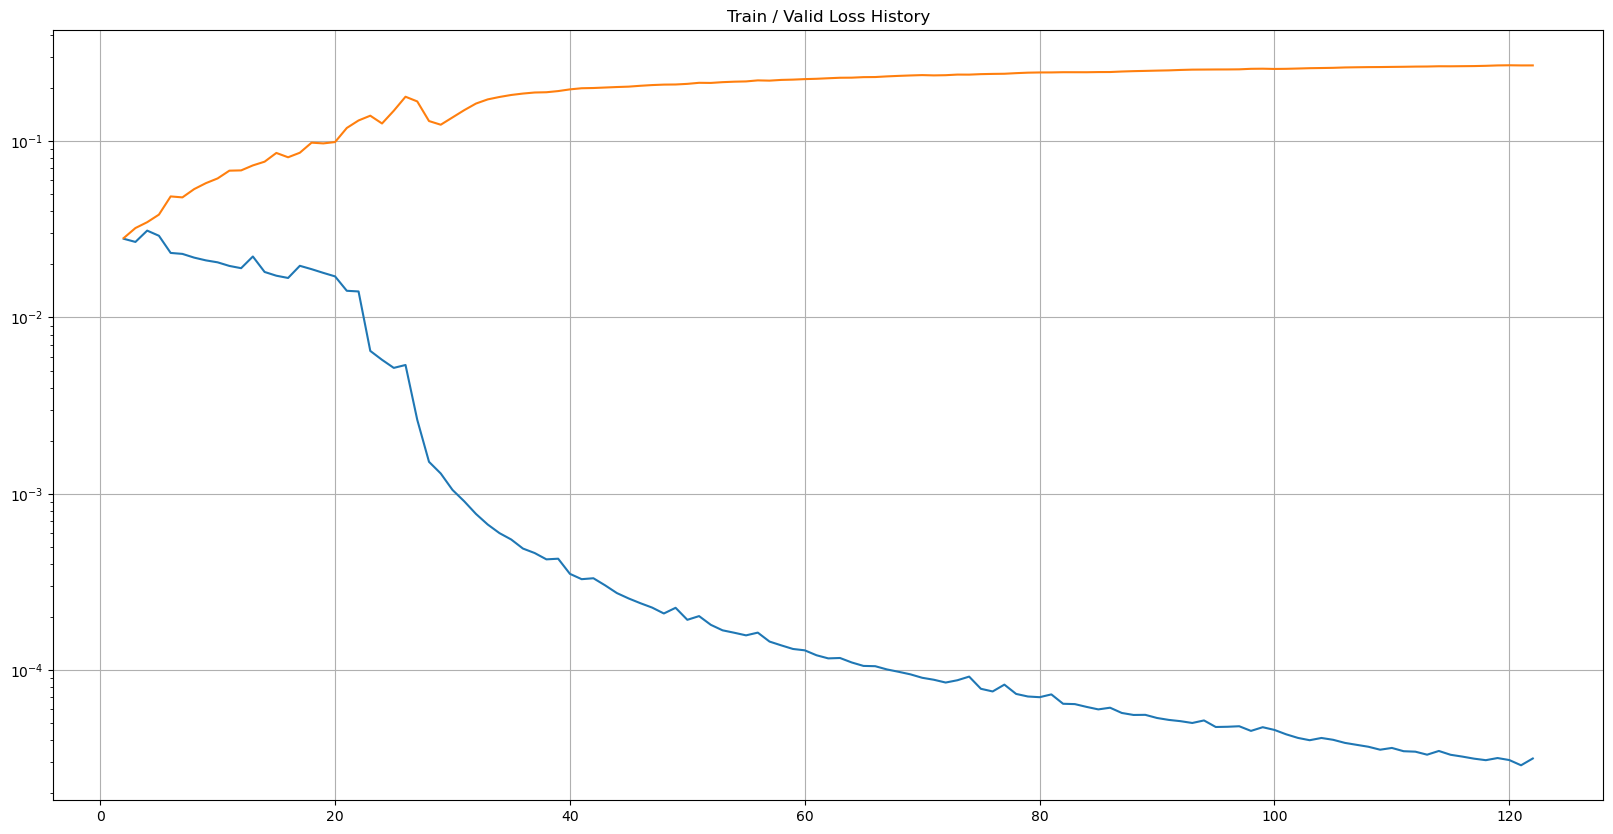

In [ ]:
plot_from = 2
plt.figure(figsize = (20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(range(plot_from, len(train_history)), 
         train_history[plot_from:], range(plot_from, len(valid_history)), 
         valid_history[plot_from:],)

plt.yscale("log")
plt.show()

In [ ]:
test_loss = 0
y_hat = []

with torch.no_grad() :
		x_ = x[2].split(batch_size, dim = 0)
		y_ = y[2].split(batch_size, dim = 0)

		for x_i , y_i in zip(x_, y_) :
				y_hat_i = model(x_i)
				loss = F.binary_cross_entropy(y_hat_i, y_i)
				test_loss += loss
				y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim = 0)

sorted_history = sorted(zip(train_history, valid_history), key = lambda x : x[1]) #

print("Train loss : %.4e"%sorted_history[0][0])
print("Valid loss : %.4e"%sorted_history[0][1])
print("Test loss : %.4e" % test_loss)

Train loss : 3.0524e-02
Valid loss : 2.4853e-02
Test loss : 1.8681e-01


In [ ]:
correct_cnt = (y[2] == (y_hat > .5)).sum()
total_cnt = float(y[2].size(0))

print("test Accuracy : %.4f" % (correct_cnt / total_cnt))

test Accuracy : 0.0522


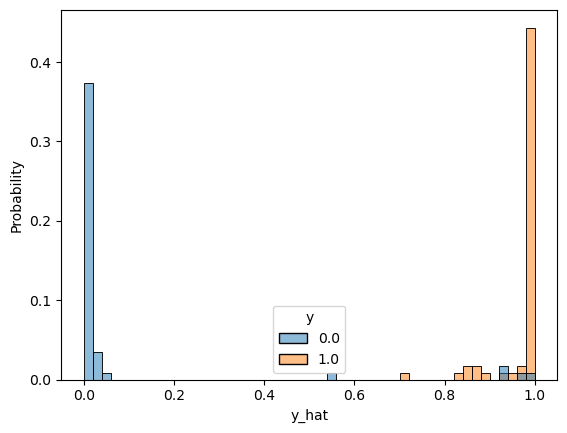

In [ ]:
import seaborn as sns
df = pd.DataFrame(torch.cat([y[2], y_hat], dim = 1).detach().numpy(), columns = ["y","y_hat"])

sns.histplot(df, x = 'y_hat', hue = 'y', bins = 50, stat = 'probability')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df.values[:,0], df.values[:,1])

0.9863055386488132